## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1.  compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.image import imsave as mpsave
from matplotlib.image import imread as mpread
%matplotlib qt

def get_calibration_mtx():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = mpread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

### Computer camera calibration matrix, and store it

In [ ]:
%matplotlib qt
mtx, dist = get_calibration_mtx()

import pickle
with open('dump.pkl', 'wb') as f:
    pickle.dump(
        {
            'mtx': mtx,
            'dist': dist,
        }, f, pickle.HIGHEST_PROTOCOL)

### reload the previously loaded calibration result

In [2]:
import pickle
with open('dump.pkl', 'rb') as f:
    pickle_data = pickle.load(f)
    mtx = pickle_data['mtx']
    dist = pickle_data['dist']

## 2. use the calibration for new image testing  

In [3]:
%matplotlib inline
import numpy as np

def testimg_calibration(mtx, dist):
    images = glob.glob('../camera_cal/calibration*.jpg')
    testidx = np.random.randint(0, len(images))
    print('test on image file ', images[testidx])
    img = mpread(images[testidx])

    dst = cv2.undistort(img, mtx, dist, None, mtx)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

test on image file  ../camera_cal\calibration20.jpg


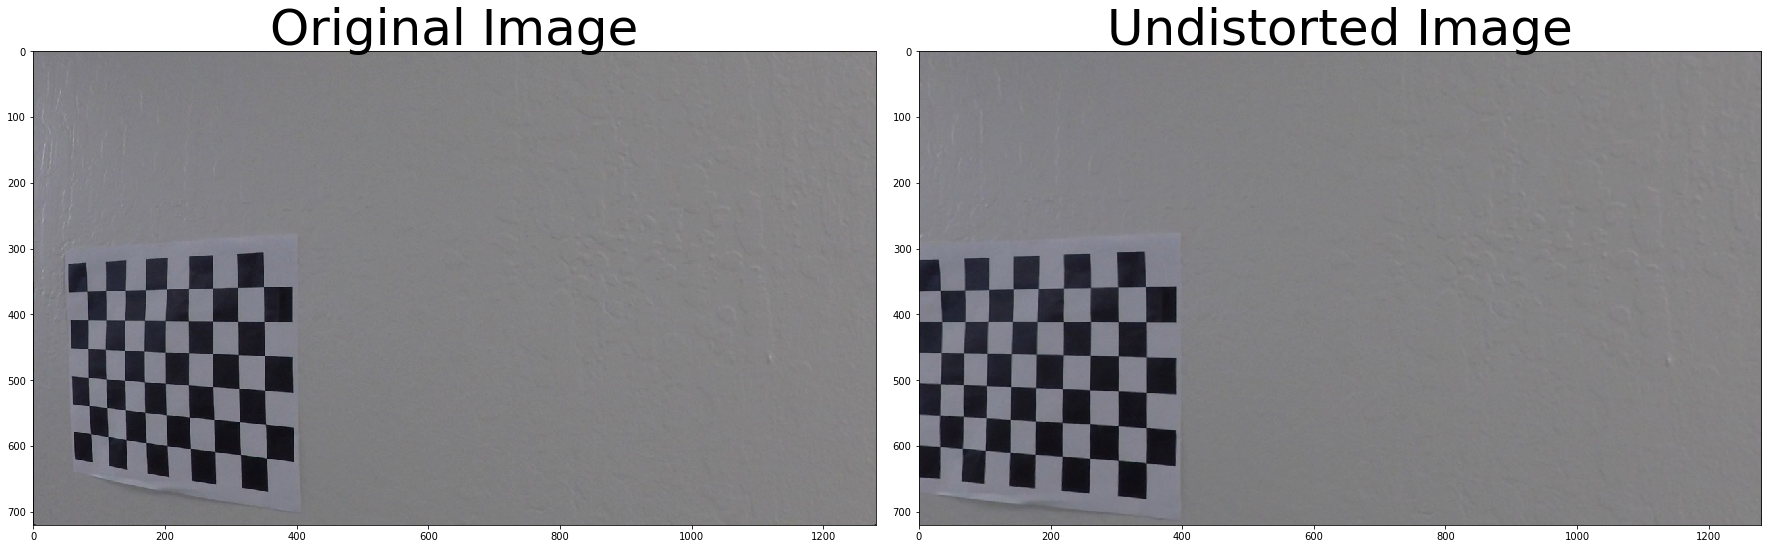

In [4]:
testimg_calibration(mtx, dist)


## 3 Apply a perspective transform to rectify binary image ("birds-eye view").
find a proper image to do the perspective transform


In [5]:
import os
%matplotlib inline
def get_perspective_transform_mtx():
    pers_img = os.path.join('..', 'test_images', 'straight_lines1.jpg')
    print(pers_img)
    img = mpread(pers_img)
    plt.imshow(img)
    src = np.float32([[560, 460], [720, 460], [1250, 720], [40, 720]])
    dst = np.float32([[100, 0], [1060, 0], [1060, 700], [100, 700]])
        
    src = np.float32([[490, 482],[800, 482], [1250, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0], [1200, 720],[40, 720]])
    '''
          0   1
           ---
          /   \
         /     \
        /       \
        ---------
       3         2 
    '''
    plt.plot(*src[0], '.', color = 'r')
    plt.plot(*src[1], '.', color = 'r')
    plt.plot(*src[2], '.', color = 'r')
    plt.plot(*src[3], '.', color = 'r')
    plt.plot(*dst[0], 'x', color = 'y')
    plt.plot(*dst[1], 'x', color = 'y')
    plt.plot(*dst[2], 'x', color = 'y')
    plt.plot(*dst[3], 'x', color = 'y')

    # computer the perspective transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv


### calculate perspective transformation info and save them in a pickle file

..\test_images\straight_lines1.jpg


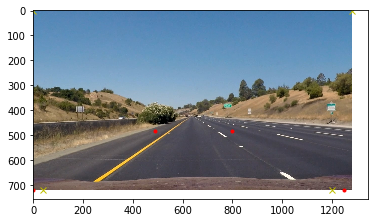

In [6]:
M, Minv = get_perspective_transform_mtx()

import pickle
with open('dump2.pkl', 'wb') as f:
    pickle.dump(
        {
            'M': M,
            'Minv': Minv,
        }, f, pickle.HIGHEST_PROTOCOL)

### reload perspective transformation info from previously saved pickle file


In [7]:
import pickle
with open('dump2.pkl', 'rb') as f:
    pickle_data = pickle.load(f)
    M = pickle_data['M']
    Minv = pickle_data['Minv']

test and check the perspective transformation

In [8]:
import os
def testimg_perspective_transform(m, imgidx = 1):
    # do transformation on the test image
    # check the final warped image after perspective transformation
    imgname = os.path.join('..', 'test_images', 'straight_lines' + str(imgidx) + '.jpg')
    print(imgname)
    img = mpread(imgname)    
    img_size = img.shape[1], img.shape[0]
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    plt.imshow(warped)


..\test_images\straight_lines1.jpg


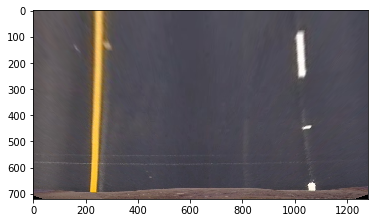

In [9]:
testimg_perspective_transform(M, imgidx = 1)   

..\test_images\straight_lines2.jpg


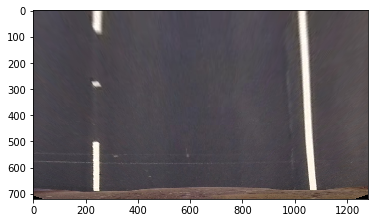

In [10]:
testimg_perspective_transform(M, imgidx = 2)  

## 4. Use color transforms, gradients, etc., to create a thresholded binary image.
define a function called bin img selection

In [11]:
from cv2 import Sobel
def build_binary_img(img, rawtype = 'rgb', channeltype = 'gray', gradient = None, thresh = (170, 255)):
    if rawtype == 'rgb':
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        rgb = img
        luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    elif rawtype == 'bgr':
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    else:
        assert 0, 'rawtype should be bgr or rgb'
    
    channelname = channeltype.lower()
    if channelname ==  'gray':
        channel = gray
    elif channelname == 'rgb_r':
        channel = rgb[:,:,0]
    elif channelname == 'rgb_g':
        channel = rgb[:,:,1]
    elif channelname == 'rgb_b':
        channel = rgb[:,:,2]
    elif channelname == 'hls_h':
        channel = hls[:,:,0]
    elif channelname == 'hls_l':
        channel = hls[:,:,1]
    elif channelname == 'hls_s':
        channel = hls[:,:,2]
    elif channelname == 'luv_l':
        channel = luv[:, :, 0]
    elif channelname == 'luv_u':
        channel = luv[:, :, 1]
    elif channelname == 'luv_v':
        channel = luv[:, :, 2]
    elif channelname == 'lab_l':
        channel = lab[:, :, 0]
    elif channelname == 'lab_a':
        channel = lab[:, :, 1]
    elif channelname == 'lab_b':
        channel = lab[:,:,2]
    else:
        assert 0, 'channel name ' + channelname + ' not valid'
        
    if gradient != None:
        if gradient.lower() == 'x':
            newimg = Sobel(channel, cv2.CV_64F, 1, 0)
        else:
            newimg = Sobel(channel, cv2.CV_64F, 0, 1)
        newimg = np.absolute(newimg)
        newimg = np.int8(255 * newimg / np.max(newimg))
    else:
        newimg = channel
    
    result = np.zeros_like(newimg)
    result[(newimg >= thresh[0]) & (newimg <= thresh[1])] = 1
    return result


def combine_imgs(bin_img1, bin_img2):
    assert bin_img1.shape == bin_img2.shape
    combined = np.zeros_like(bin_img1)
    combined[(bin_img1 > 0) | (bin_img2 > 0)] = 1
    return combined

def gray_img(bin_img):
    return bin_img * 255

def build_gray_img(color_img, rawtype, channeltype ):
    assert rawtype == 'rgb' or rawtype == 'bgr', 'raw type should be rgb or bgr'
    if  channeltype in ['rgb_r', 'rgb_g', 'rgb_b'] and rawtype == 'bgr':
        if channeltype == 'rgb_r':
            return color_img[:,:,2]
        elif channeltype == 'rgb_g':
            return color_img[:,:,1]
        else:
            return color_img[:,:,0]
    elif channeltype in ['rgb_r', 'rgb_g', 'rgb_b'] and rawtype == 'rgb':
        if channeltype == 'rgb_r':
            return color_img[:,:,0]
        elif channeltype == 'rgb_g':
            return color_img[:,:,1]
        else:
            return color_img[:,:,2]
    elif channeltype in ['hls_h', 'hls_l', 'hls_s']:
        if rawtype == 'bgr':
            img = cv2.cvtColor(color_img, cv2.COLOR_BGR2HLS)
        elif rawtype == 'rgb':
            img = cv2.cvtColor(color_img, cv2.COLOR_RGB2HLS)
            
        if channeltype == 'hls_h':
            return img[:, :, 0]
        elif channeltype == 'hls_l':
            return img[:, :, 1]
        else:
            return img[:, :, 2]
    elif channeltype == 'gray':
        if rawtype == 'rgb':
            return cv2.cvtColor(color_img, cv2.COLOR_RGB2GRAY)
        elif rawtype == 'bgr':
            return cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)

### test build_binary_img function

In [12]:
import os
def testimg_build_binary(picidx = 6):
    
    imgname = os.path.join('..', 'test_images', 'test' + str(picidx)+'.jpg')
    print('testing the binary img build function on image: ', imgname)
    imgraw = mpread(imgname)
    
    img_undistort = cv2.undistort(imgraw, mtx, dist, None, mtx)
    img = cv2.warpPerspective(img_undistort, M, (img_undistort.shape[1], img_undistort.shape[0]), flags=cv2.INTER_LINEAR)
    
    img01 = build_binary_img(img, rawtype = 'rgb', channeltype = 'gray', thresh = (210,255))
    img02 = build_binary_img(img, rawtype = 'rgb', channeltype = 'gray', gradient = 'x', thresh= (50, 100))
    img03 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'gray')
    
    img04 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_r', thresh = (200, 255))
    img05 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_r', gradient = 'x', thresh= (40, 100))
    img06 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'rgb_r')
    
    img07 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_g')
    img08 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_g', gradient = 'x', thresh= (20, 100))
    img09 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'rgb_g')
    
    img10 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_b', thresh = (155, 200))
    img11 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_b', gradient = 'x', thresh= (20, 100))
    img12 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'rgb_b')
    
    img13 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_h')
    img14 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_h', gradient = 'x', thresh= (20, 100))
    img15 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'hls_h')
    
    img16 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_l', thresh = (200, 255))
    img17 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_l', gradient = 'x', thresh= (20, 100))
    img18 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'hls_l')
    
    img19 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_s', thresh = (180, 255))
    img20 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_s', gradient = 'x', thresh= (20, 100))
    img21 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'hls_s')
    
    img22 = build_binary_img(img, rawtype = 'rgb',   channeltype = 'luv_l', thresh = (225, 255))
    img23 = build_binary_img(img, rawtype = 'rgb',   channeltype = 'lab_b', thresh = (155, 200))
    
    f, ax = plt.subplots(9, 3, figsize=(48, 98))
    f.tight_layout()
   
    
    ax[0][0].imshow(imgraw)
    ax[0][0].set_title('Original Image', fontsize=32)
    
    ax[0][1].imshow( img_undistort)
    ax[0][1].set_title('undistorted Image', fontsize=32)
    
    ax[0][2].imshow(img)
    ax[0][2].set_title('warp perspective img', fontsize=32)    


    ax[1][0].imshow(gray_img(img01), cmap = 'gray')
    ax[1][0].set_title('gray threshold img', fontsize = 32)
    
    ax[1][1].imshow(gray_img(img02), cmap = 'gray')
    ax[1][1].set_title('gray x sobel threshold img', fontsize = 32)
    
    ax[1][2].imshow(gray_img(img03), cmap = 'gray')
    ax[1][2].set_title('gray img', fontsize = 32)

    
    ax[2][0].imshow(gray_img(img04), cmap = 'gray')
    ax[2][0].set_title('r threshold img', fontsize = 32)
    
    ax[2][1].imshow(gray_img(img05), cmap = 'gray')
    ax[2][1].set_title('r x sobel threshold img', fontsize = 32)
    
    ax[2][2].imshow(img06, cmap = 'gray')
    ax[2][2].set_title('r img', fontsize = 32)
    
    
    ax[3][0].imshow(gray_img(img07), cmap = 'gray')
    ax[3][0].set_title('g threshold img', fontsize = 32)

    ax[3][1].imshow(gray_img(img08), cmap = 'gray')
    ax[3][1].set_title('g x sobel threshold img', fontsize = 32)
    
    ax[3][2].imshow(img09, cmap = 'gray')
    ax[3][2].set_title('g  img', fontsize = 32)
    
    
    ax[4][0].imshow(gray_img(img10), cmap = 'gray')
    ax[4][0].set_title('b threshold img', fontsize = 32)
    
    ax[4][1].imshow(gray_img(img11), cmap = 'gray')
    ax[4][1].set_title('b x sobel threshold img', fontsize = 32)
    
    ax[4][2].imshow(img12, cmap = 'gray')
    ax[4][2].set_title('b  img', fontsize = 32)
    
    
    ax[5][0].imshow(gray_img(img13), cmap = 'gray')
    ax[5][0].set_title('h threshold img', fontsize = 32)
    
    ax[5][1].imshow(gray_img(img14), cmap = 'gray')
    ax[5][1].set_title('h x sobel threshold img', fontsize = 32)
    
    ax[5][2].imshow(img15, cmap = 'gray')
    ax[5][2].set_title('h  img', fontsize = 32)
    
    
    ax[6][0].imshow(gray_img(img16), cmap = 'gray')
    ax[6][0].set_title('l threshold img', fontsize = 32)
    
    ax[6][1].imshow(gray_img(img17), cmap = 'gray')
    ax[6][1].set_title('l x sobel threshold img', fontsize = 32)
    
    ax[6][2].imshow(img18, cmap = 'gray')
    ax[6][2].set_title('l img', fontsize = 32)
    
    
    ax[7][0].imshow(gray_img(img19), cmap = 'gray')
    ax[7][0].set_title('s threshold img', fontsize = 32)
    
    ax[7][1].imshow(gray_img(img20), cmap = 'gray')
    ax[7][1].set_title('s x sobel threshold img', fontsize = 32)
    
    ax[7][2].imshow(img21, cmap = 'gray')
    ax[7][2].set_title('s  img', fontsize = 32)
    
    
    ax[8][0].imshow(gray_img(img22), cmap = 'gray')
    ax[8][0].set_title('luv l channel threshold img', fontsize = 32)
    
    ax[8][1].imshow(gray_img(img23), cmap = 'gray')
    ax[8][1].set_title('lab b channel threshold img', fontsize = 32)
    
    plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0, wspace=None, hspace=0.4)
    
    # return the raw input img, the img after undistortion and perspective transformation
    return imgraw, img

testing the binary img build function on image:  ..\test_images\test6.jpg


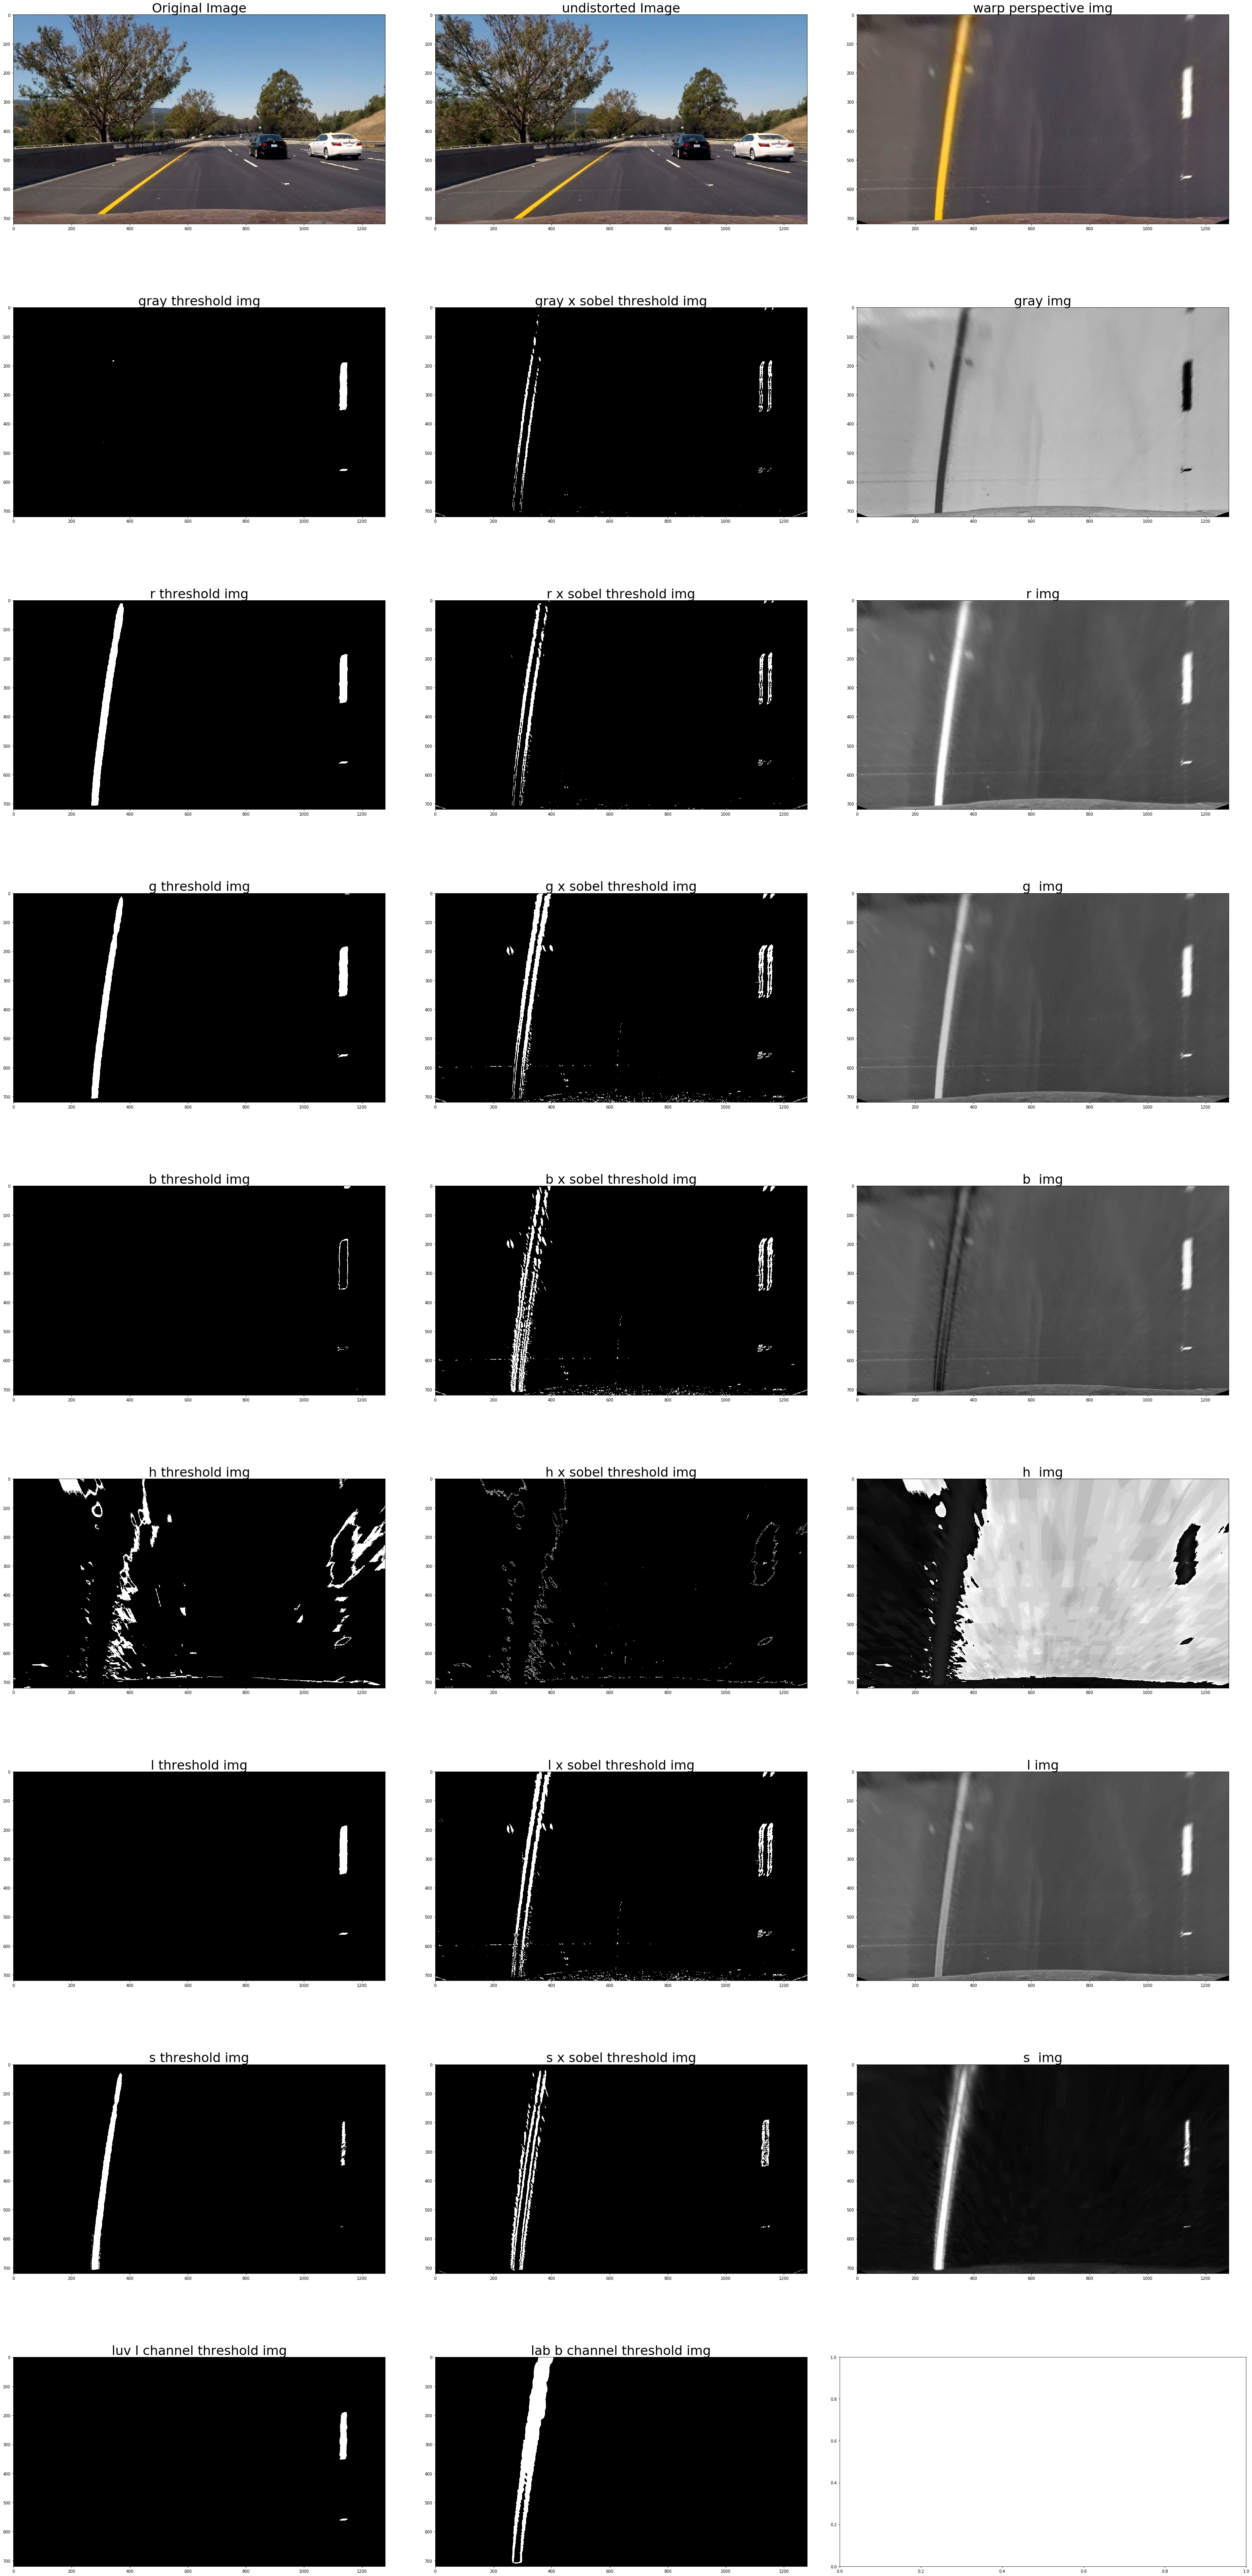

In [13]:
img_raw6, img_basic6 = testimg_build_binary(picidx = 6)

In [14]:
def get_histogram(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # as in the persepctive transformation, we have already changed the bottom half to the whole image,
    # then no need to only use the bottom half, just use the whole half
    # but actually when we detect the base lane x-position, we had better consider the bottom half as the lan maybe curving
    histogram = np.sum( img[img.shape[0]//2:,:], axis=0)
    out_img = np.dstack((img, img, img))   
    return histogram

In [15]:
# img_basic is the combined binary image we will do lane finding

# histogram = get_histogram(img_basic1)
# histogram = get_histogram(img_basic2)
# histogram = get_histogram(img_basic3)
# histogram = get_histogram(img_basic4)
# histogram = get_histogram(img_basic5)
histogram = get_histogram(img_basic6)

### using the binary image to get the xm_per_pix and ym_per_pix


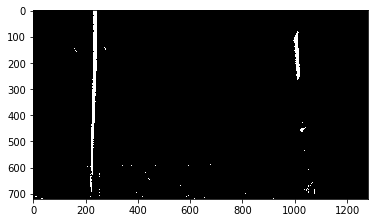

In [16]:
import os
def get_xm_per_pix():
    # we use a straight line img, e.g., test_imgs/straignt_lines1.jpg for calc
    # 1. do un-distortion
    # 2. perspective change
    # 3. get the left and right lane distance by pixel
    # 4. comparing with the real value, we assume 3.5m, 
    # return the xm_per_pix
    imgname = os.path.join('..', 'test_images', 'straight_lines1.jpg')
    img = mpread(imgname)
    img_size = img.shape[1], img.shape[0]
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(dst, M, img_size, flags=cv2.INTER_LINEAR)
    gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    
    color_thresh = (170, 255)
    sobel_thresh = (20, 100)
    
    sobelx = Sobel(gray, cv2.CV_64F, 1, 0)
    sobelx = np.uint8(255*sobelx/np.max(sobelx))
    sobel_bin = np.zeros_like(sobelx)
    sobel_bin[(sobelx >= sobel_thresh[0]) & (sobelx <= sobel_thresh[1])] = 255

    
    hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    
    plt.imshow(sobel_bin, cmap = 'gray')
    hist = get_histogram(sobel_bin)
    
    midpoint = np.int(hist.shape[0]/2)
    leftx_base = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint
    lane_line_pixel = rightx_base - leftx_base
    lane_line_meter = 3.7
    xm_per_pixel = lane_line_meter / lane_line_pixel
    return xm_per_pixel
xm_per_pixel = get_xm_per_pix()        

Sliding Window

### 7. Warp the detected lane boundaries back onto the original image.

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### 9. final pipe line function

# pipe line for video

In [28]:
def get_threshold_bin_img(img):
    # for video pipeline, the readin img is RGB format
    b_channel = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2]
    l_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0]  
    # Set the upper and lower thresholds for the b channel
    b_thresh_min = 145
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1

    # Set the upper and lower thresholds for the l channel
    l_thresh_min = 215
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    gray_channel = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_thresh_min = 210
    gray_thresh_max = 255
    gray_binary = np.zeros_like(gray_channel)
    gray_binary[(gray_channel >= gray_thresh_min) & (gray_channel <= gray_thresh_max)] = 1
    
    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1) | (gray_binary == 1)] = 1
    return combined_binary

In [18]:
def blind_search(img, nwins, left_right):
    xvals = []
    yvals = []
    xsize, ysize = img.shape[1], img.shape[0]
    xmid = int(xsize/2)
    height = np.int(ysize /nwins) 
    x,y = np.nonzero(np.transpose(img))
    for win in range(nwins):
        # loop from img top to bottom
        histogram = np.sum(img[win * height: (win+1)*height, :], axis = 0)
        if left_right == 'left':
            peak = np.argmax(histogram[:xmid])
        else:
            peak = np.argmax(histogram[xmid:]) + xmid

        x_idx = np.where((((peak - 25) < x) & 
                          (x < (peak + 25)) &
                          ((y > win*height) & (y < (win+1)* height))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            xvals.extend(x_window)
            yvals.extend(y_window)
    return xvals, yvals

In [19]:
def based_on_previous_search(img, prev_fittings,nwins):
    # here prev_fittings[0], prev_fittings[1], prev_fittings[2] store previous fitting frame img value
    xvals = []
    yvals = []
    xsize, ysize = img.shape[1], img.shape[0]
    xmid = xsize/2
    height = np.int(ysize /nwins) 
    x,y = np.nonzero(np.transpose(img))
    for win in range(nwins):
        #loop from top to down
        ymid = np.mean([win * height, (win +1) * height])

        xmid = (np.mean(prev_fittings[0]))*ymid**2 +(np.mean(prev_fittings[1]))*ymid + (np.mean(prev_fittings[2]))
        x_idx = np.where((((xmid - 25) < x) & (x < (xmid + 25))&((y > win*height) & (y < (win+1) * height))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            np.append(xvals, x_window)
            np.append(yvals, y_window)
    return xvals, yvals

In [24]:
# we use a class to collect all the variables together in a scope

# use it as global as it not changed [y_pixdels, x_pixels]
imgsize = img_basic6.shape[:2]
print(imgsize)

# the difference between LaneLineHandler2 and laneLineHandler is 
# LaneLineHander2 use the previous img left_x_base as the starting point for windows sliding
# while LaneLineHandler use histogram to detect the starting point
class LaneLineHandler2(object):
    def __init__(self, saved_dir = None):
        self.nwindows = 8
        self.window_height = np.int(imgsize[0]/self.nwindows)
        self.margin = 50
        # self.minpix = 50
        self.ym_per_pix = 30./720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700
    
        self.mtx = mtx
        self.dist = dist
        
        self.left_reuse_count = 0
        self.right_reuse_count = 0
        
        self.saved_dir = saved_dir
        self.img_count = 0
        self.nodata = False
        
        # for senalty check
        self.last_offset = None
        self.last_left_curvature_meter = None
        self.last_right_curvature_meter = None
        self.last_left_slope = []
        self.last_right_slope = []
        
        self.last_left_fittings = [[], [], [] ]
        self.last_right_fittings = [[], [], []]
        
        self.last_left_fittings_meter = [[], [], [] ]
        self.last_right_fittings_meter = [[], [], []]
        
    def run(self, img):
        self.readin(img)
        self.finding_pixels()
        self.fitting()
        result = self.drawBack()
        return result

        
    def readin(self, img, rawtype = 'rgb'):
        print('read in the img index:', self.img_count)
        # readin the raw color image taken from the camera
        self.img_count += 1
        img = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        self.img_raw = img
        self.nodata = False
        
        if self.saved_dir != None:
            filename = self.saved_dir + str(self.img_count) + '_0raw.jpg'
            mpsave(filename, self.img_raw)
        
        self.img_warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
        self.img_basic = get_threshold_bin_img(self.img_warped)
        x, y = np.nonzero(np.transpose(self.img_basic))
        if len(x) == 0:
            print('no data for fitting, using previous img')
            self.nodata = True
        return

    
    def finding_pixels(self):
        # we use different strategy to do searching
        if self.nodata == True:
            print('no data')
            self.leftx, self.lefty, self.rightx, self.righty = [], [], [], []
            self.left_nodata = True
            self.right_nodata = True
        else:
            self.left_nodata = False
            self.right_nodata = False
            if self.left_reuse_count >= 6 or self.img_count <= 1:
                self.leftx, self.lefty = blind_search(self.img_basic, self.nwindows, 'left')
                print('left blind search')
            else:
                self.leftx, self.lefty = based_on_previous_search(self.img_basic, self.last_left_fittings, self.nwindows)
                print('left based previous search')
                if len(self.leftx) == 0 or len(self.rightx) == 0:
                    self.leftx, self.lefty = blind_search(self.img_basic, self.nwindows, 'left')
            
            if self.right_reuse_count >= 6 or self.img_count <= 1:
                self.rightx, self.righty = blind_search(self.img_basic, self.nwindows, 'right')
            else:
                self.rightx, self.righty = based_on_previous_search(self.img_basic, self.last_right_fittings, self.nwindows)
                if len(self.rightx) == 0:
                    self.rightx, self.righty = blind_search(self.img_basic, self.nwindows, 'right')
            
            if len(self.leftx) == 0:
                self.left_nodata = True
            if len(self.rightx) == 0:
                self.right_nodata = True
            
            
            
    def senaltyCheck(self):
        # we handle left and right separately
        left_reuse, right_reuse = False, False
        
        # check if need to reuse left
        if self.left_reuse_count > 6:
            left_reuse = False
        elif self.img_count <= 1:
            left_reuse = False
        else:
            if self.left_nodata == True:
                print('left lane no data, reuse previous left lane line')
                left_reuse = True
            elif self.last_left_pos != None and abs(self.last_left_pos - self.left_pos) > 0.1:
                print('left lane switched too much, reuse previous left lane line')
                left_reuse = True
            elif self.last_left_curvature_meter != None and abs(self.last_left_curvature_meter - self.left_curvature_meter) > 4000:
                print('left curvature meter changed too much, reuse previous left lane line')
                left_reuse = True
        
        # check if need to reuse right
        if self.right_reuse_count > 6:
            right_reuse = False
        elif self.img_count <= 1:
            right_reuse = False
        else:
            if self.right_nodata == True:
                print('right lane no data, reuse previous right lane line')
                right_reuse = True
            elif self.last_right_pos != None and abs(self.last_right_pos - self.right_pos) > 0.1:
                print('right lane switched too much, reuse previous right lane line')
                right_reuse = True
            elif self.last_right_curvature_meter != None and abs(self.last_right_curvature_meter - self.right_curvature_meter) > 4000:
                print('right curvature meter changed too much, reuse previous left lane line')
                right_reuse = True
                
                
        if left_reuse == True:
            self.left_reuse_count += 1
            self.offset = self.last_offset
            self.left_pos = self.last_left_pos 
            self.left_curvature_meter = self.last_left_curvature_meter
            assert len(self.last_left_fittings[0]) >= 1
            self.left_fit = [ self.last_left_fittings[0][-1],
                            self.last_left_fittings[1][-1],
                            self.last_left_fittings[2][-1]]
            
            self.left_fit_meter = [ self.last_left_fittings_meter[0][-1],
                                   self.last_left_fittings_meter[1][-1],
                                   self.last_left_fittings_meter[2][-1]]
        else:
            self.left_reuse_count = 0
            self.last_offset = self.offset
            self.last_left_curvature_meter = self.left_curvature_meter
            self.last_leftx = self.leftx
            self.last_lefty = self.lefty
            self.last_left_pos = self.left_pos
            for i in range(3):
                self.last_left_fittings[i].append(self.left_fit[i])
                if len(self.last_left_fittings[i]) > 10:
                    self.last_left_fittings[i] = self.last_left_fittings[i][-10:]
                
                self.last_left_fittings_meter[i].append(self.left_fit_meter[i])
                if len(self.last_left_fittings_meter[i]) > 10:
                    self.last_left_fittings_meter[i] = self.last_left_fittings_meter[i][-10:]
                    
        if right_reuse == True:
            self.right_reuse_count += 1
            self.offset = self.last_offset
            self.right_pos = self.last_right_pos
            self.right_curvature_meter = self.last_right_curvature_meter
            assert len(self.last_right_fittings[0]) >= 1
            self.right_fit = [ self.last_right_fittings[0][-1],
                            self.last_right_fittings[1][-1],
                            self.last_right_fittings[2][-1]]
            
            self.right_fit_meter = [ self.last_right_fittings_meter[0][-1],
                                   self.last_right_fittings_meter[1][-1],
                                   self.last_right_fittings_meter[2][-1]]
        else:
            self.right_reuse_count = 0
            self.last_offset = self.offset
            self.last_right_curvature_meter = self.right_curvature_meter
            self.last_rightx = self.rightx
            self.last_righty = self.righty
            self.last_right_pos = self.right_pos
            for i in range(3):
                self.last_right_fittings[i].append(self.right_fit[i])
                if len(self.last_right_fittings[i]) > 10:
                    self.last_right_fittings[i] = self.last_right_fittings[i][-10:]
                
                self.last_right_fittings_meter[i].append(self.right_fit_meter[i])
                if len(self.last_right_fittings_meter[i]) > 10:
                    self.last_right_fittings_meter[i] = self.last_right_fittings_meter[i][-10:]
        
    def fitting(self):
        # no data for current, then do re-use previous frame img pixels
        if len(self.leftx) == 0:
            self.leftx = self.last_leftx
            self.lefty = self.last_lefty
        if len(self.rightx) == 0:
            self.rightx = self.last_rightx
            self.righty = self.last_righty
                
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
        self.right_fit = np.polyfit(self.righty, self.rightx, 2)
        
        # self.left_fit_meter = np.polyfit(self.lefty * self.ym_per_pix, self.leftx * self.xm_per_pix, 2)
        # self.right_fit_meter = np.polyfit(self.righty * self.ym_per_pix, self.rightx * self.xm_per_pix, 2)
        self.left_fit_meter = np.polyfit([y * self.ym_per_pix for y in self.lefty],[x* self.xm_per_pix for x in self.leftx], 2)
        self.right_fit_meter = np.polyfit([y * self.ym_per_pix for y in self.righty], [x*self.xm_per_pix for x in self.rightx], 2)
        
    
    def calcOffset(self):
        car_left = self.left_fit[0]*720**2 + self.left_fit[1]*720 + self.left_fit[2]
        car_right = self.right_fit[0]*720**2 + self.right_fit[1]*720 + self.right_fit[2]
        car_center = (car_left + car_right) /2.0
        self.left_pos = car_left
        self.right_pos = car_right
        self.offset = (car_center - 640)* self.xm_per_pix
        
    def calcCurvature(self):
        ploty = np.linspace(0, self.img_basic.shape[0]-1, self.img_basic.shape[0] )

        y_eval = np.max(ploty)
        # calc the curvature at the bottom,e.g., close to the car
        # x = a*y^2 + b*y + c 
        # R_curve = [1 + (2a+b)^2]^(3/2)/ |2a|


        self.left_curvature = ((1 + (2*self.left_fit[0]*y_eval + self.left_fit[1])**2)**1.5) / np.absolute(2*self.left_fit[0])
        self.right_curvature= ((1 + (2*self.right_fit[0]*y_eval + self.right_fit[1])**2)**1.5) / np.absolute(2*self.right_fit[0])
        
        left_fitting0 = np.mean(self.last_left_fittings[0])
        left_fitting1 = np.mean(self.last_left_fittings[1])
        left_fitting2 = np.mean(self.last_left_fittings[2])
        right_fitting0 = np.mean(self.last_right_fittings[0])
        right_fitting1 = np.mean(self.last_right_fittings[1])
        right_fitting2 = np.mean(self.last_right_fittings[2])
        
        self.left_curvature = ((1 + (2*left_fitting0*y_eval + left_fitting1)**2)**1.5) / np.absolute(2*left_fitting0)
        self.right_curvature= ((1 + (2*right_fitting0*y_eval + right_fitting1)**2)**1.5) / np.absolute(2*right_fitting0)
        
        y_eval = y_eval * self.ym_per_pix
        self.left_curvature_meter =((1 + (2*self.left_fit_meter[0]* y_eval + self.left_fit_meter[1])**2)**1.5) / np.absolute(2*self.left_fit_meter[0])
        self.right_curvature_meter = ((1 + (2*self.right_fit_meter[0] * y_eval + self.right_fit_meter[1])**2)**1.5) / np.absolute(2*self.right_fit_meter[0])
        
        left_fitting0 = np.mean(self.last_left_fittings_meter[0])
        left_fitting1 = np.mean(self.last_left_fittings_meter[1])
        left_fitting2 = np.mean(self.last_left_fittings_meter[2])
        right_fitting0 = np.mean(self.last_right_fittings_meter[0])
        right_fitting1 = np.mean(self.last_right_fittings_meter[1])
        right_fitting2 = np.mean(self.last_right_fittings_meter[2])
        
        self.left_curvature_meter =((1 + (2*left_fitting0* y_eval + left_fitting1)**2)**1.5) / np.absolute(2*left_fitting0)
        self.right_curvature_meter = ((1 + (2*right_fitting0 * y_eval + right_fitting1)**2)**1.5) / np.absolute(2*right_fitting0)
        
    
    def drawBack(self):
        if self.saved_dir != None:
            filename = self.saved_dir + str(self.img_count) + '_0raw.jpg'
            mpsave(filename, self.img_raw)
            

        # Create an image to draw the lines on
        color_warp = np.zeros_like(self.img_raw).astype(np.uint8)
        
        ploty = np.linspace(0, self.img_basic.shape[0]-1, self.img_basic.shape[0] )
        
        self.calcOffset()
        self.calcCurvature()
        self.senaltyCheck()

        left_fitting0 = np.mean(self.last_left_fittings[0])
        left_fitting1 = np.mean(self.last_left_fittings[1])
        left_fitting2 = np.mean(self.last_left_fittings[2])
        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        left_fitx = left_fitting0*ploty**2 + left_fitting1*ploty + left_fitting2
        
        right_fitting0 = np.mean(self.last_right_fittings[0])
        right_fitting1 = np.mean(self.last_right_fittings[1])
        right_fitting2 = np.mean(self.last_right_fittings[2])
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
        right_fitx = right_fitting0 * ploty**2 + right_fitting1*ploty + right_fitting2


        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (self.img_basic.shape[1], self.img_basic.shape[0])) 
        
        # Combine the result with the original image
        result = cv2.addWeighted(self.img_raw, 1, newwarp, 0.3, 0)
        # plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        
        # write the curvature and position information
        font = cv2.FONT_HERSHEY_SIMPLEX
                
        text = 'Curvature Radius: '+ '{0:.1f}'.format(self.left_curvature_meter/2.0 + self.right_curvature_meter/2.0 ) + ' m'
        cv2.putText(result, text, (50,100), font, 1.5, (255,255,255),2, cv2.LINE_AA)

    
        if self.offset > 0:
            text = 'Vehicle is ' + '{0:.2f}'.format(self.offset) + ' m left of center'
        else:
            text = 'Vehicle is ' + '{0:.2f}'.format(- self.offset) + ' m right of center' 
        cv2.putText(result, text, (50,200), font, 1.5, (255,255,255),2, cv2.LINE_AA)
        
        if self.left_reuse_count == 0:
            text = 'left lane recalc'
        else:
            text = 'reuse left lane= ' + str(self.left_reuse_count)
        if self.right_reuse_count == 0:
            text += '/right lane recalc'
        else:
            text += '/reuse right lane = '+ str(self.right_reuse_count)
            
        cv2.putText(result, text, (50, 300), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)

        if self.saved_dir != None:
            filename = self.saved_dir + str(self.img_count) + '_1warped.jpg'
            cv2.imwrite(filename, self.img_warped)
            filename = self.saved_dir + str(self.img_count) + '_2basic.jpg'
            cv2.imwrite(filename, self.img_basic*255)
#             filename = self.saved_dir + str(self.img_count) + '_3fitting.jpg'
#             cv2.imwrite(filename, self.out_color)
            
        return result

(720, 1280)


In [25]:
g_handler2 = LaneLineHandler2()
def get_handler2():
    return g_handler2

In [26]:
def process_image2(img):
    handler = get_handler2()
    result = handler.run(img)
    return result

In [27]:
from moviepy.editor import VideoFileClip
video_input = '../project_video.mp4'
video_output = '../project_solution.mp4'
# challenge_output = 'test_videos_output/challenge.mp4'

g_handler2 = LaneLineHandler2('../videoimg_project/')
# g_handler2 = LaneLineHandler2()

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
# clip1 = VideoFileClip(video_input)
clip1 = VideoFileClip(video_input).subclip(0,1)
# clip1 = VideoFileClip(video_input)
challenge_clip = clip1.fl_image(process_image2)
%time challenge_clip.write_videofile(video_output, audio=False)

read in the img index: 0
left blind search
[MoviePy] >>>> Building video ../project_solution.mp4
[MoviePy] Writing video ../project_solution.mp4



  0%|                                                                                           | 0/26 [00:00<?, ?it/s]

read in the img index: 1
left based previous search



  4%|███▏                                                                               | 1/26 [00:01<00:31,  1.28s/it]

read in the img index: 2
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line



  8%|██████▍                                                                            | 2/26 [00:02<00:31,  1.30s/it]

read in the img index: 3
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line



 12%|█████████▌                                                                         | 3/26 [00:03<00:28,  1.26s/it]

read in the img index: 4
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line



 15%|████████████▊                                                                      | 4/26 [00:04<00:26,  1.20s/it]

read in the img index: 5
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line



 19%|███████████████▉                                                                   | 5/26 [00:05<00:24,  1.17s/it]

read in the img index: 6
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line



 23%|███████████████████▏                                                               | 6/26 [00:07<00:23,  1.16s/it]

read in the img index: 7
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line



 27%|██████████████████████▎                                                            | 7/26 [00:08<00:21,  1.13s/it]

read in the img index: 8
left blind search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line



 31%|█████████████████████████▌                                                         | 8/26 [00:09<00:20,  1.11s/it]

read in the img index: 9
left blind search



 35%|████████████████████████████▋                                                      | 9/26 [00:10<00:18,  1.09s/it]

read in the img index: 10
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line



 38%|███████████████████████████████▌                                                  | 10/26 [00:11<00:17,  1.08s/it]

read in the img index: 11
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line



 42%|██████████████████████████████████▋                                               | 11/26 [00:12<00:16,  1.10s/it]

read in the img index: 12
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line



 46%|█████████████████████████████████████▊                                            | 12/26 [00:13<00:15,  1.10s/it]

read in the img index: 13
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line



 50%|█████████████████████████████████████████                                         | 13/26 [00:14<00:14,  1.11s/it]

read in the img index: 14
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line



 54%|████████████████████████████████████████████▏                                     | 14/26 [00:15<00:13,  1.14s/it]

read in the img index: 15
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line



 58%|███████████████████████████████████████████████▎                                  | 15/26 [00:17<00:12,  1.16s/it]

read in the img index: 16
left blind search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line



 62%|██████████████████████████████████████████████████▍                               | 16/26 [00:18<00:11,  1.16s/it]

read in the img index: 17
left blind search



 65%|█████████████████████████████████████████████████████▌                            | 17/26 [00:19<00:10,  1.19s/it]

read in the img index: 18
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line



 69%|████████████████████████████████████████████████████████▊                         | 18/26 [00:20<00:09,  1.21s/it]

read in the img index: 19
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line



 73%|███████████████████████████████████████████████████████████▉                      | 19/26 [00:22<00:08,  1.24s/it]

read in the img index: 20
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line



 77%|███████████████████████████████████████████████████████████████                   | 20/26 [00:23<00:07,  1.24s/it]

read in the img index: 21
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line



 81%|██████████████████████████████████████████████████████████████████▏               | 21/26 [00:24<00:06,  1.25s/it]

read in the img index: 22
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line



 85%|█████████████████████████████████████████████████████████████████████▍            | 22/26 [00:25<00:05,  1.27s/it]

read in the img index: 23
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line



 88%|████████████████████████████████████████████████████████████████████████▌         | 23/26 [00:27<00:03,  1.33s/it]

read in the img index: 24
left blind search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line



 92%|███████████████████████████████████████████████████████████████████████████▋      | 24/26 [00:28<00:02,  1.37s/it]

read in the img index: 25
left blind search



 96%|██████████████████████████████████████████████████████████████████████████████▊   | 25/26 [00:30<00:01,  1.38s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_solution.mp4 

Wall time: 31.7 s


In [27]:

from moviepy.editor import VideoFileClip
challenge_input = '../challenge_video.mp4'
challenge_output = '../challenge_solution.mp4'
# challenge_output = 'test_videos_output/challenge.mp4'

# renew handler
g_handler2 = LaneLineHandler2('../videoimg_challenge/')
# g_handler2 = LaneLineHandler2()

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
# clip2 = VideoFileClip(challenge_input)
clip2 = VideoFileClip(challenge_input).subclip(0, 5)
challenge_clip = clip2.fl_image(process_image2)
%time challenge_clip.write_videofile(challenge_output, audio=False)

read in the img index: 0
left blind search
[MoviePy] >>>> Building video ../challenge_solution.mp4
[MoviePy] Writing video ../challenge_solution.mp4


  0%|                                                                                          | 0/150 [00:00<?, ?it/s]

read in the img index: 1
left based previous search


  1%|▌                                                                                 | 1/150 [00:01<02:45,  1.11s/it]

read in the img index: 2
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


  1%|█                                                                                 | 2/150 [00:02<02:49,  1.15s/it]

read in the img index: 3
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


  2%|█▋                                                                                | 3/150 [00:03<02:51,  1.17s/it]

read in the img index: 4
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


  3%|██▏                                                                               | 4/150 [00:04<02:45,  1.14s/it]

read in the img index: 5
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


  3%|██▋                                                                               | 5/150 [00:05<02:46,  1.15s/it]

read in the img index: 6
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


  4%|███▎                                                                              | 6/150 [00:06<02:44,  1.14s/it]

read in the img index: 7
left based previous search
left lane switched too much, reuse previous left lane line
right lane no data, reuse previous right lane line


  5%|███▊                                                                              | 7/150 [00:08<02:44,  1.15s/it]

read in the img index: 8
left blind search
right lane no data, reuse previous right lane line


  5%|████▎                                                                             | 8/150 [00:09<02:39,  1.13s/it]

read in the img index: 9
left based previous search
left lane switched too much, reuse previous left lane line


  6%|████▉                                                                             | 9/150 [00:10<02:41,  1.15s/it]

read in the img index: 10
left based previous search
left lane switched too much, reuse previous left lane line
right lane no data, reuse previous right lane line


  7%|█████▍                                                                           | 10/150 [00:11<02:38,  1.13s/it]

read in the img index: 11
left based previous search
left lane switched too much, reuse previous left lane line
right lane no data, reuse previous right lane line


  7%|█████▉                                                                           | 11/150 [00:12<02:36,  1.13s/it]

read in the img index: 12
left based previous search
left lane switched too much, reuse previous left lane line
right lane no data, reuse previous right lane line


  8%|██████▍                                                                          | 12/150 [00:13<02:35,  1.13s/it]

read in the img index: 13
left based previous search
left lane switched too much, reuse previous left lane line
right lane no data, reuse previous right lane line


  9%|███████                                                                          | 13/150 [00:14<02:32,  1.11s/it]

read in the img index: 14
left based previous search
left lane switched too much, reuse previous left lane line
right lane no data, reuse previous right lane line


  9%|███████▌                                                                         | 14/150 [00:15<02:29,  1.10s/it]

read in the img index: 15
left blind search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 10%|████████                                                                         | 15/150 [00:16<02:27,  1.09s/it]

read in the img index: 16
left blind search
right lane switched too much, reuse previous right lane line


 11%|████████▋                                                                        | 16/150 [00:18<02:27,  1.10s/it]

read in the img index: 17
left based previous search


 11%|█████████▏                                                                       | 17/150 [00:19<02:28,  1.11s/it]

read in the img index: 18
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 12%|█████████▋                                                                       | 18/150 [00:20<02:27,  1.12s/it]

read in the img index: 19
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 13%|██████████▎                                                                      | 19/150 [00:21<02:24,  1.10s/it]

read in the img index: 20
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 13%|██████████▊                                                                      | 20/150 [00:22<02:22,  1.10s/it]

read in the img index: 21
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 14%|███████████▎                                                                     | 21/150 [00:23<02:20,  1.09s/it]

read in the img index: 22
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 15%|███████████▉                                                                     | 22/150 [00:24<02:19,  1.09s/it]

read in the img index: 23
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 15%|████████████▍                                                                    | 23/150 [00:25<02:18,  1.09s/it]

read in the img index: 24
left blind search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 16%|████████████▉                                                                    | 24/150 [00:26<02:16,  1.09s/it]

read in the img index: 25
left blind search


 17%|█████████████▌                                                                   | 25/150 [00:27<02:13,  1.07s/it]

read in the img index: 26
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 17%|██████████████                                                                   | 26/150 [00:28<02:13,  1.07s/it]

read in the img index: 27
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 18%|██████████████▌                                                                  | 27/150 [00:30<02:13,  1.08s/it]

read in the img index: 28
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 19%|███████████████                                                                  | 28/150 [00:31<02:12,  1.08s/it]

read in the img index: 29
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 19%|███████████████▋                                                                 | 29/150 [00:32<02:11,  1.09s/it]

read in the img index: 30
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 20%|████████████████▏                                                                | 30/150 [00:33<02:11,  1.10s/it]

read in the img index: 31
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 21%|████████████████▋                                                                | 31/150 [00:34<02:11,  1.11s/it]

read in the img index: 32
left blind search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 21%|█████████████████▎                                                               | 32/150 [00:35<02:12,  1.12s/it]

read in the img index: 33
left blind search


 22%|█████████████████▊                                                               | 33/150 [00:36<02:06,  1.08s/it]

read in the img index: 34
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 23%|██████████████████▎                                                              | 34/150 [00:37<02:03,  1.06s/it]

read in the img index: 35
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 23%|██████████████████▉                                                              | 35/150 [00:38<02:00,  1.05s/it]

read in the img index: 36
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 24%|███████████████████▍                                                             | 36/150 [00:39<02:00,  1.06s/it]

read in the img index: 37
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 25%|███████████████████▉                                                             | 37/150 [00:40<01:58,  1.05s/it]

read in the img index: 38
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 25%|████████████████████▌                                                            | 38/150 [00:41<01:58,  1.06s/it]

read in the img index: 39
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 26%|█████████████████████                                                            | 39/150 [00:42<01:56,  1.05s/it]

read in the img index: 40
left blind search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 27%|█████████████████████▌                                                           | 40/150 [00:43<01:54,  1.04s/it]

read in the img index: 41
left blind search


 27%|██████████████████████▏                                                          | 41/150 [00:44<01:52,  1.03s/it]

read in the img index: 42
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 28%|██████████████████████▋                                                          | 42/150 [00:46<01:56,  1.08s/it]

read in the img index: 43
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 29%|███████████████████████▏                                                         | 43/150 [00:47<01:58,  1.10s/it]

read in the img index: 44
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 29%|███████████████████████▊                                                         | 44/150 [00:48<01:54,  1.08s/it]

read in the img index: 45
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 30%|████████████████████████▎                                                        | 45/150 [00:49<01:53,  1.08s/it]

read in the img index: 46
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 31%|████████████████████████▊                                                        | 46/150 [00:50<01:57,  1.13s/it]

read in the img index: 47
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 31%|█████████████████████████▍                                                       | 47/150 [00:51<01:55,  1.12s/it]

read in the img index: 48
left blind search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 32%|█████████████████████████▉                                                       | 48/150 [00:52<01:51,  1.10s/it]

read in the img index: 49
left blind search


 33%|██████████████████████████▍                                                      | 49/150 [00:53<01:48,  1.08s/it]

read in the img index: 50
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 33%|███████████████████████████                                                      | 50/150 [00:54<01:47,  1.08s/it]

read in the img index: 51
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 34%|███████████████████████████▌                                                     | 51/150 [00:55<01:46,  1.08s/it]

read in the img index: 52
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 35%|████████████████████████████                                                     | 52/150 [00:56<01:45,  1.07s/it]

read in the img index: 53
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 35%|████████████████████████████▌                                                    | 53/150 [00:58<01:43,  1.07s/it]

read in the img index: 54
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 36%|█████████████████████████████▏                                                   | 54/150 [00:59<01:42,  1.07s/it]

read in the img index: 55
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 37%|█████████████████████████████▋                                                   | 55/150 [01:00<01:41,  1.07s/it]

read in the img index: 56
left blind search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 37%|██████████████████████████████▏                                                  | 56/150 [01:01<01:43,  1.10s/it]

read in the img index: 57
left blind search


 38%|██████████████████████████████▊                                                  | 57/150 [01:02<01:39,  1.07s/it]

read in the img index: 58
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 39%|███████████████████████████████▎                                                 | 58/150 [01:03<01:37,  1.06s/it]

read in the img index: 59
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 39%|███████████████████████████████▊                                                 | 59/150 [01:04<01:36,  1.06s/it]

read in the img index: 60
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 40%|████████████████████████████████▍                                                | 60/150 [01:05<01:34,  1.05s/it]

read in the img index: 61
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 41%|████████████████████████████████▉                                                | 61/150 [01:06<01:33,  1.05s/it]

read in the img index: 62
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 41%|█████████████████████████████████▍                                               | 62/150 [01:07<01:31,  1.04s/it]

read in the img index: 63
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 42%|██████████████████████████████████                                               | 63/150 [01:08<01:29,  1.03s/it]

read in the img index: 64
left blind search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 43%|██████████████████████████████████▌                                              | 64/150 [01:09<01:28,  1.03s/it]

read in the img index: 65
left blind search


 43%|███████████████████████████████████                                              | 65/150 [01:10<01:26,  1.02s/it]

read in the img index: 66
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 44%|███████████████████████████████████▋                                             | 66/150 [01:11<01:25,  1.02s/it]

read in the img index: 67
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 45%|████████████████████████████████████▏                                            | 67/150 [01:12<01:24,  1.02s/it]

read in the img index: 68
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 45%|████████████████████████████████████▋                                            | 68/150 [01:13<01:23,  1.02s/it]

read in the img index: 69
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 46%|█████████████████████████████████████▎                                           | 69/150 [01:14<01:23,  1.03s/it]

read in the img index: 70
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 47%|█████████████████████████████████████▊                                           | 70/150 [01:15<01:23,  1.05s/it]

read in the img index: 71
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 47%|██████████████████████████████████████▎                                          | 71/150 [01:16<01:21,  1.04s/it]

read in the img index: 72
left blind search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 48%|██████████████████████████████████████▉                                          | 72/150 [01:17<01:20,  1.03s/it]

read in the img index: 73
left blind search


 49%|███████████████████████████████████████▍                                         | 73/150 [01:18<01:17,  1.01s/it]

read in the img index: 74
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 49%|███████████████████████████████████████▉                                         | 74/150 [01:19<01:19,  1.05s/it]

read in the img index: 75
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 50%|████████████████████████████████████████▌                                        | 75/150 [01:21<01:22,  1.11s/it]

read in the img index: 76
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 51%|█████████████████████████████████████████                                        | 76/150 [01:22<01:23,  1.12s/it]

read in the img index: 77
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 51%|█████████████████████████████████████████▌                                       | 77/150 [01:23<01:23,  1.15s/it]

read in the img index: 78
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 52%|██████████████████████████████████████████                                       | 78/150 [01:24<01:22,  1.14s/it]

read in the img index: 79
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 53%|██████████████████████████████████████████▋                                      | 79/150 [01:25<01:18,  1.10s/it]

read in the img index: 80
left blind search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 53%|███████████████████████████████████████████▏                                     | 80/150 [01:26<01:15,  1.08s/it]

read in the img index: 81
left blind search


 54%|███████████████████████████████████████████▋                                     | 81/150 [01:27<01:14,  1.08s/it]

read in the img index: 82
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 55%|████████████████████████████████████████████▎                                    | 82/150 [01:28<01:11,  1.06s/it]

read in the img index: 83
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 55%|████████████████████████████████████████████▊                                    | 83/150 [01:29<01:10,  1.05s/it]

read in the img index: 84
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 56%|█████████████████████████████████████████████▎                                   | 84/150 [01:30<01:08,  1.04s/it]

read in the img index: 85
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 57%|█████████████████████████████████████████████▉                                   | 85/150 [01:31<01:07,  1.04s/it]

read in the img index: 86
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 57%|██████████████████████████████████████████████▍                                  | 86/150 [01:32<01:06,  1.04s/it]

read in the img index: 87
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 58%|██████████████████████████████████████████████▉                                  | 87/150 [01:33<01:05,  1.04s/it]

read in the img index: 88
left blind search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 59%|███████████████████████████████████████████████▌                                 | 88/150 [01:34<01:03,  1.03s/it]

read in the img index: 89
left blind search


 59%|████████████████████████████████████████████████                                 | 89/150 [01:35<01:02,  1.02s/it]

read in the img index: 90
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 60%|████████████████████████████████████████████████▌                                | 90/150 [01:36<01:00,  1.01s/it]

read in the img index: 91
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 61%|█████████████████████████████████████████████████▏                               | 91/150 [01:37<00:58,  1.00it/s]

read in the img index: 92
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 61%|█████████████████████████████████████████████████▋                               | 92/150 [01:38<00:57,  1.02it/s]

read in the img index: 93
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 62%|██████████████████████████████████████████████████▏                              | 93/150 [01:39<00:55,  1.02it/s]

read in the img index: 94
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 63%|██████████████████████████████████████████████████▊                              | 94/150 [01:40<00:54,  1.03it/s]

read in the img index: 95
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 63%|███████████████████████████████████████████████████▎                             | 95/150 [01:41<00:53,  1.03it/s]

read in the img index: 96
left blind search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 64%|███████████████████████████████████████████████████▊                             | 96/150 [01:42<00:52,  1.03it/s]

read in the img index: 97
left blind search


 65%|████████████████████████████████████████████████████▍                            | 97/150 [01:43<00:51,  1.03it/s]

read in the img index: 98
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 65%|████████████████████████████████████████████████████▉                            | 98/150 [01:44<00:50,  1.02it/s]

read in the img index: 99
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 66%|█████████████████████████████████████████████████████▍                           | 99/150 [01:45<00:50,  1.02it/s]

read in the img index: 100
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 67%|█████████████████████████████████████████████████████▎                          | 100/150 [01:46<00:48,  1.02it/s]

read in the img index: 101
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 67%|█████████████████████████████████████████████████████▊                          | 101/150 [01:47<00:48,  1.02it/s]

read in the img index: 102
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 68%|██████████████████████████████████████████████████████▍                         | 102/150 [01:48<00:47,  1.00it/s]

read in the img index: 103
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 69%|██████████████████████████████████████████████████████▉                         | 103/150 [01:49<00:47,  1.01s/it]

read in the img index: 104
left blind search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 69%|███████████████████████████████████████████████████████▍                        | 104/150 [01:50<00:46,  1.01s/it]

read in the img index: 105
left blind search


 70%|████████████████████████████████████████████████████████                        | 105/150 [01:51<00:45,  1.01s/it]

read in the img index: 106
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 71%|████████████████████████████████████████████████████████▌                       | 106/150 [01:52<00:44,  1.01s/it]

read in the img index: 107
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 71%|█████████████████████████████████████████████████████████                       | 107/150 [01:53<00:44,  1.03s/it]

read in the img index: 108
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 72%|█████████████████████████████████████████████████████████▌                      | 108/150 [01:54<00:43,  1.04s/it]

read in the img index: 109
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 73%|██████████████████████████████████████████████████████████▏                     | 109/150 [01:55<00:42,  1.03s/it]

read in the img index: 110
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 73%|██████████████████████████████████████████████████████████▋                     | 110/150 [01:56<00:41,  1.04s/it]

read in the img index: 111
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 74%|███████████████████████████████████████████████████████████▏                    | 111/150 [01:57<00:41,  1.05s/it]

read in the img index: 112
left blind search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 75%|███████████████████████████████████████████████████████████▋                    | 112/150 [01:59<00:39,  1.05s/it]

read in the img index: 113
left blind search


 75%|████████████████████████████████████████████████████████████▎                   | 113/150 [02:00<00:38,  1.03s/it]

read in the img index: 114
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 76%|████████████████████████████████████████████████████████████▊                   | 114/150 [02:01<00:37,  1.04s/it]

read in the img index: 115
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 77%|█████████████████████████████████████████████████████████████▎                  | 115/150 [02:02<00:36,  1.04s/it]

read in the img index: 116
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 77%|█████████████████████████████████████████████████████████████▊                  | 116/150 [02:03<00:35,  1.03s/it]

read in the img index: 117
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 78%|██████████████████████████████████████████████████████████████▍                 | 117/150 [02:04<00:33,  1.02s/it]

read in the img index: 118
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 79%|██████████████████████████████████████████████████████████████▉                 | 118/150 [02:05<00:32,  1.01s/it]

read in the img index: 119
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 79%|███████████████████████████████████████████████████████████████▍                | 119/150 [02:06<00:30,  1.00it/s]

read in the img index: 120
left blind search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 80%|████████████████████████████████████████████████████████████████                | 120/150 [02:06<00:29,  1.03it/s]

read in the img index: 121
left blind search


 81%|████████████████████████████████████████████████████████████████▌               | 121/150 [02:07<00:26,  1.08it/s]

read in the img index: 122
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 81%|█████████████████████████████████████████████████████████████████               | 122/150 [02:08<00:25,  1.10it/s]

read in the img index: 123
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 82%|█████████████████████████████████████████████████████████████████▌              | 123/150 [02:09<00:23,  1.13it/s]

read in the img index: 124
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 83%|██████████████████████████████████████████████████████████████████▏             | 124/150 [02:10<00:22,  1.15it/s]

read in the img index: 125
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 83%|██████████████████████████████████████████████████████████████████▋             | 125/150 [02:11<00:21,  1.17it/s]

read in the img index: 126
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 84%|███████████████████████████████████████████████████████████████████▏            | 126/150 [02:11<00:20,  1.18it/s]

read in the img index: 127
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 85%|███████████████████████████████████████████████████████████████████▋            | 127/150 [02:12<00:19,  1.20it/s]

read in the img index: 128
left blind search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 85%|████████████████████████████████████████████████████████████████████▎           | 128/150 [02:13<00:18,  1.20it/s]

read in the img index: 129
left blind search


 86%|████████████████████████████████████████████████████████████████████▊           | 129/150 [02:14<00:17,  1.23it/s]

read in the img index: 130
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 87%|█████████████████████████████████████████████████████████████████████▎          | 130/150 [02:15<00:16,  1.24it/s]

read in the img index: 131
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 87%|█████████████████████████████████████████████████████████████████████▊          | 131/150 [02:15<00:15,  1.25it/s]

read in the img index: 132
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 88%|██████████████████████████████████████████████████████████████████████▍         | 132/150 [02:16<00:14,  1.25it/s]

read in the img index: 133
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 89%|██████████████████████████████████████████████████████████████████████▉         | 133/150 [02:17<00:14,  1.19it/s]

read in the img index: 134
no data for fitting, using previous img
no data
left lane no data, reuse previous left lane line
right lane no data, reuse previous right lane line


 89%|███████████████████████████████████████████████████████████████████████▍        | 134/150 [02:18<00:13,  1.19it/s]

read in the img index: 135
left based previous search
left lane no data, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 90%|████████████████████████████████████████████████████████████████████████        | 135/150 [02:19<00:12,  1.18it/s]

read in the img index: 136
left blind search
left lane no data, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 91%|████████████████████████████████████████████████████████████████████████▌       | 136/150 [02:20<00:12,  1.15it/s]

read in the img index: 137
left blind search


 91%|█████████████████████████████████████████████████████████████████████████       | 137/150 [02:21<00:11,  1.16it/s]

read in the img index: 138
left based previous search
left lane no data, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 92%|█████████████████████████████████████████████████████████████████████████▌      | 138/150 [02:21<00:10,  1.18it/s]

read in the img index: 139
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 93%|██████████████████████████████████████████████████████████████████████████▏     | 139/150 [02:22<00:09,  1.20it/s]

read in the img index: 140
left based previous search
left lane no data, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 93%|██████████████████████████████████████████████████████████████████████████▋     | 140/150 [02:23<00:08,  1.20it/s]

read in the img index: 141
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 94%|███████████████████████████████████████████████████████████████████████████▏    | 141/150 [02:24<00:07,  1.19it/s]

read in the img index: 142
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 95%|███████████████████████████████████████████████████████████████████████████▋    | 142/150 [02:25<00:06,  1.16it/s]

read in the img index: 143
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 95%|████████████████████████████████████████████████████████████████████████████▎   | 143/150 [02:26<00:06,  1.14it/s]

read in the img index: 144
left blind search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 96%|████████████████████████████████████████████████████████████████████████████▊   | 144/150 [02:27<00:05,  1.15it/s]

read in the img index: 145
left blind search


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 145/150 [02:27<00:04,  1.16it/s]

read in the img index: 146
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 146/150 [02:28<00:03,  1.14it/s]

read in the img index: 147
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 147/150 [02:29<00:02,  1.10it/s]

read in the img index: 148
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 148/150 [02:30<00:01,  1.06it/s]

read in the img index: 149
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


 99%|███████████████████████████████████████████████████████████████████████████████▍| 149/150 [02:31<00:00,  1.03it/s]

read in the img index: 150
left based previous search
left lane switched too much, reuse previous left lane line
right lane switched too much, reuse previous right lane line


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [02:33<00:00,  1.02s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../challenge_solution.mp4 

Wall time: 2min 35s


In [ ]:
from moviepy.editor import VideoFileClip
harder_challenge_input = '../harder_challenge_video.mp4'
harder_challenge_output = '../harder_challenge_solution.mp4'

# renew handler
g_handler2 = LaneLineHandler2('../videoimg_harder/')

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
# clip3 = VideoFileClip(harder_challenge_input)
clip3 = VideoFileClip(harder_challenge_input).subclip(24, 27)

challenge_clip = clip3.fl_image(process_image2)
%time challenge_clip.write_videofile(harder_challenge_output, audio=False)